In [43]:
%update_token

Token successfully refreshed.


In [44]:
from ultralytics import YOLO
import easyocr
import cv2 as cv
import matplotlib.pyplot as plt
import time
import numpy as np
import torch
import pandas as pd

In [45]:
mlis_vehicle_tracker = YOLO("http://license-detectors-predictor.geuntak-6d6b6531.svc.cluster.local/vehicle_detector",task='detect')
mlis_vehicle_tracker_nms = YOLO("http://license-detectors-nms-predictor.geuntak-6d6b6531.svc.cluster.local/vehicle_detector",task='detect')
local_ten_batch_engine = YOLO('triton_engines_10_batches/vehicle_detector/1/model.engine')
local_vehicle_tracker = YOLO('yolo11s')

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.


In [28]:
video_path = "resources/Samples/sample.mp4"
vehicle_conf = 0.25
license_conf = 0.25
thres_frame = 10
test_length = 10
aggregated_avg = []

### Local Model engine Test - 1 batch size

In [29]:
cap = cv.VideoCapture(video_path)
fps = cap.get(cv.CAP_PROP_FPS)
total_frame = cap.get(cv.CAP_PROP_FRAME_COUNT)
frame_num = -1

time_results = []
for i in range(test_length):
    start_time = time.time()
    results = []
    while cap.isOpened():
        frame_num += 1
        ret, frame = cap.read()
        ### limit num of frames for test purpose
        if not ret or frame_num >= thres_frame:
            break
            
        vehicle_result = local_ten_batch_engine.track(frame, persist=True,conf=vehicle_conf,classes=[2,3,5,7],batch=1)[0]
        results.append(vehicle_result)
    
    final_time = time.time()
    latency = final_time - start_time
    time_results.append(latency)
    print(f"10 frame tracking: {latency:.3f} seconds")
    frame_num = -1
cap.release()

average = sum(time_results)/len(time_results)
print(f"10 frame tracking time AVG: {average:.3f} seconds")
aggregated_avg.append({"case":"local-1-batch",
                       "average":average})

Loading triton_engines_10_batches/vehicle_detector/1/model.engine for TensorRT inference...
[07/02/2025-07:49:07] [TRT] [I] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.
[07/02/2025-07:49:07] [TRT] [I] Loaded engine size: 21 MiB
[07/02/2025-07:49:07] [TRT] [I] [MS] Running engine with multi stream info
[07/02/2025-07:49:07] [TRT] [I] [MS] Number of aux streams is 1
[07/02/2025-07:49:07] [TRT] [I] [MS] Number of total worker streams is 2
[07/02/2025-07:49:07] [TRT] [I] [MS] The main stream provided by execute/enqueue calls is the first worker stream
[07/02/2025-07:49:08] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +1, GPU +892, now: CPU 1, GPU 1829 (MiB)
WARNING ⚠️ Metadata not found for 'model=triton_engines_10_batches/vehicle_detector/1/model.engine'

0: 384x640 19 class2

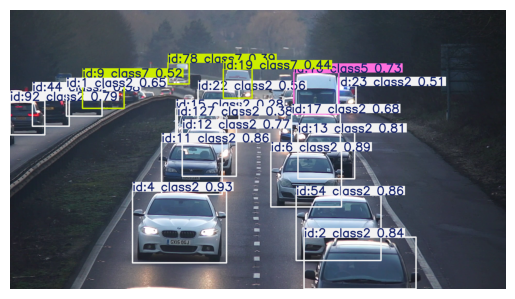

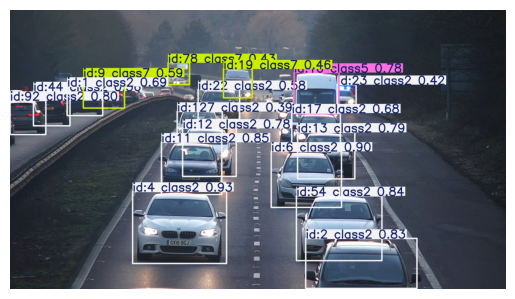

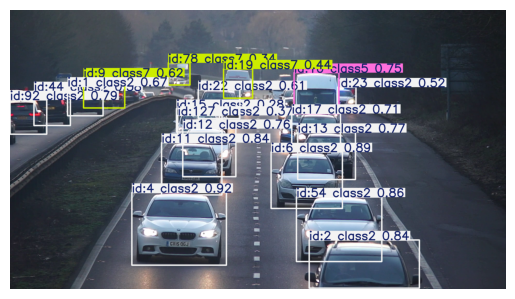

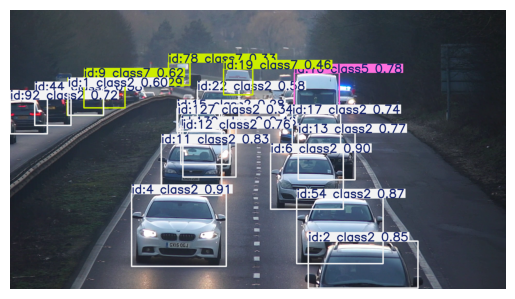

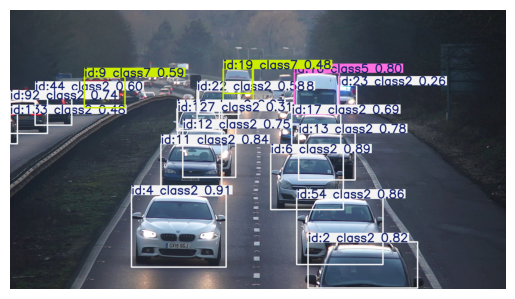

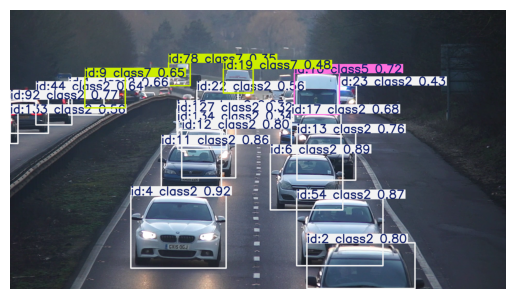

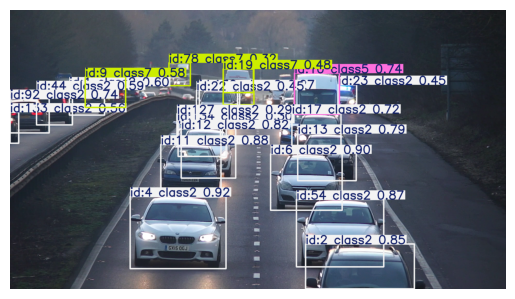

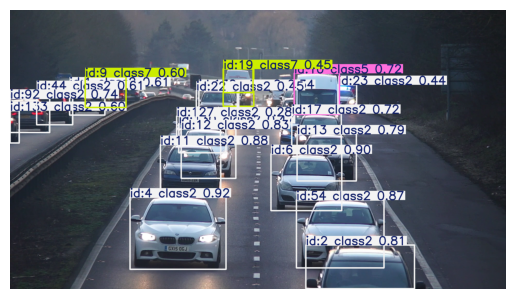

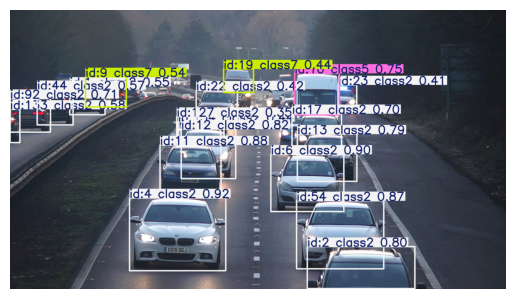

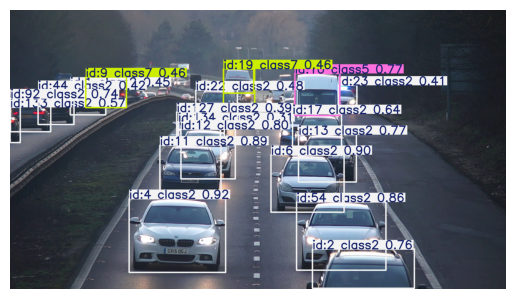

In [30]:
for rst in results:
    vehicle_rgb_img = cv.cvtColor(rst.plot(), cv.COLOR_BGR2RGB)
    plt.imshow(vehicle_rgb_img)
    plt.axis('off')
    plt.show()

### Local Model engine Test - 10 batch size

In [31]:
cap = cv.VideoCapture(video_path)
fps = cap.get(cv.CAP_PROP_FPS)
total_frame = cap.get(cv.CAP_PROP_FRAME_COUNT)
frame_num = -1

time_results = []
for i in range(test_length):
    start_time = time.time()
    frames = []
    while cap.isOpened():
        frame_num += 1
        ret, frame = cap.read()
        ### limit num of frames for test purpose
        if not ret or frame_num >= thres_frame:
            break
        
        frames.append(frame)

    local_results_engine = local_ten_batch_engine.track(frames,conf=vehicle_conf,classes=[2,3,5,7],batch=10)
    final_time = time.time()
    latency = final_time - start_time
    time_results.append(latency)
    print(f"10 frame tracking: {latency:.3f} seconds")
    frame_num = -1

cap.release()
average = sum(time_results)/len(time_results)
print(f"10 frame tracking time AVG: {average:.3f} seconds")
aggregated_avg.append({"case":"local-10-batch",
                       "average":average})


0: 384x640 9 class2s, 3 class7s, 2.4ms
1: 384x640 17 class2s, 4 class7s, 2.4ms
2: 384x640 17 class2s, 1 class5, 4 class7s, 2.4ms
3: 384x640 17 class2s, 1 class5, 4 class7s, 2.4ms
4: 384x640 17 class2s, 3 class7s, 2.4ms
5: 384x640 17 class2s, 4 class7s, 2.4ms
6: 384x640 16 class2s, 1 class5, 5 class7s, 2.4ms
7: 384x640 17 class2s, 1 class5, 5 class7s, 2.4ms
8: 384x640 17 class2s, 1 class5, 5 class7s, 2.4ms
9: 384x640 17 class2s, 5 class7s, 2.4ms
Speed: 2.7ms preprocess, 2.4ms inference, 1.3ms postprocess per image at shape (10, 3, 384, 640)
10 frame tracking: 1.122 seconds

0: 384x640 16 class2s, 1 class5, 6 class7s, 1.8ms
1: 384x640 18 class2s, 2 class5s, 3 class7s, 1.8ms
2: 384x640 18 class2s, 1 class5, 4 class7s, 1.8ms
3: 384x640 18 class2s, 1 class5, 4 class7s, 1.8ms
4: 384x640 17 class2s, 2 class5s, 3 class7s, 1.8ms
5: 384x640 17 class2s, 2 class5s, 3 class7s, 1.8ms
6: 384x640 18 class2s, 1 class5, 1 class7, 1.8ms
7: 384x640 19 class2s, 1 class5, 3 class7s, 1.8ms
8: 384x640 21 cla

In [32]:
# source = torch.rand(6, 3, 640, 640, dtype=torch.float32)
# local_results_engine = ten_batch_engine.track(source,conf=vehicle_conf,classes=[2,3,5,7],batch=10)

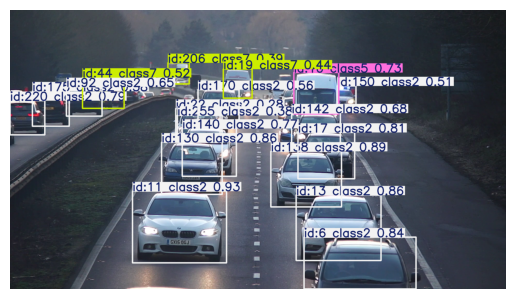

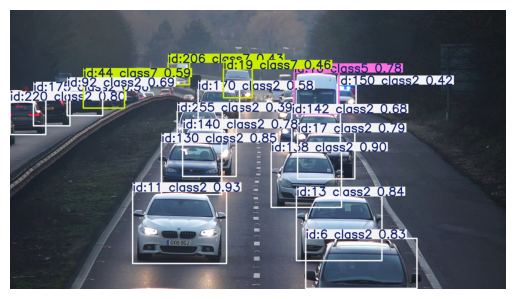

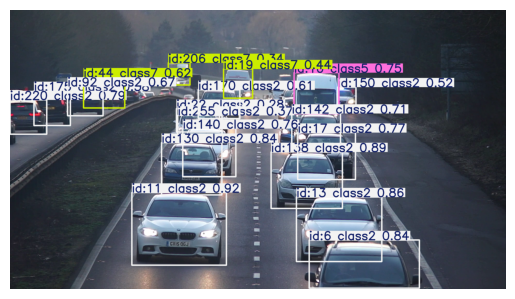

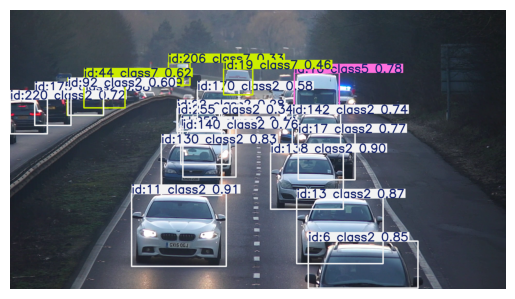

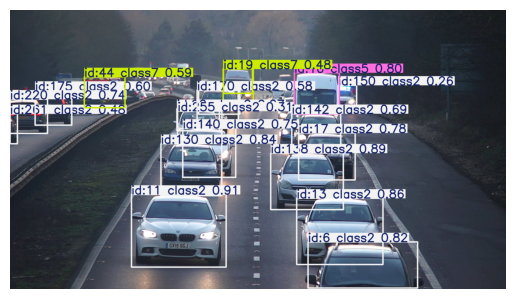

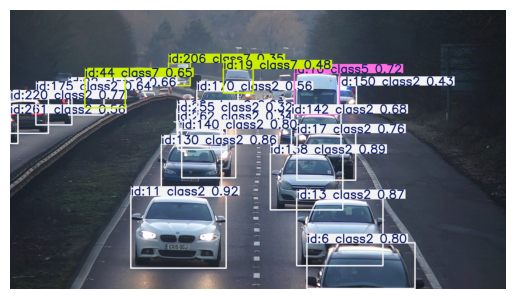

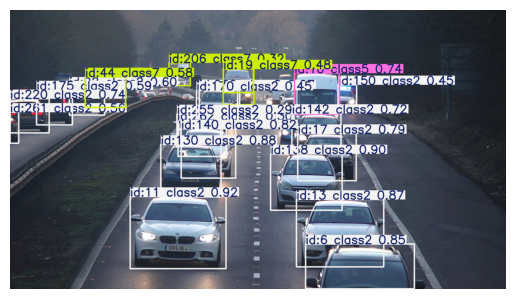

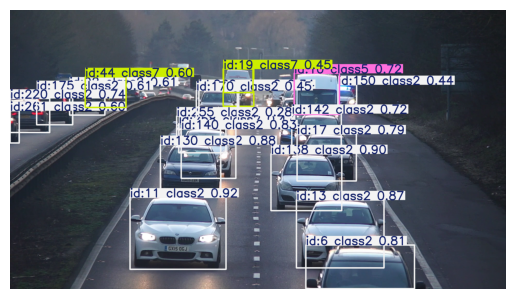

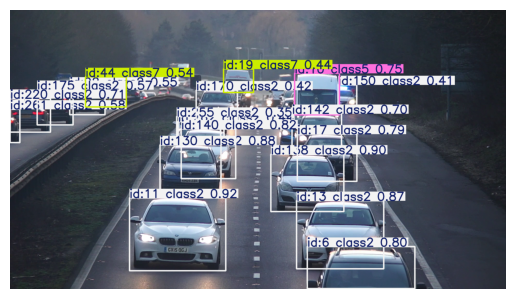

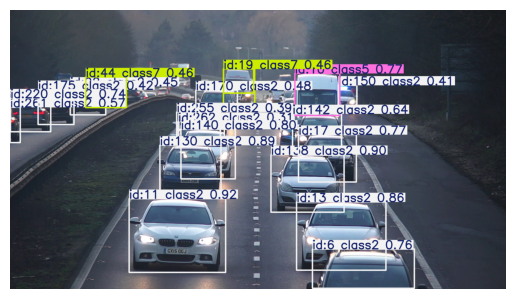

In [33]:
for rst in local_results_engine:
    vehicle_rgb_img = cv.cvtColor(rst.plot(), cv.COLOR_BGR2RGB)
    plt.imshow(vehicle_rgb_img)
    plt.axis('off')
    plt.show()

### MLIS Model engine Test - 1 batch size

In [34]:
cap = cv.VideoCapture(video_path)
fps = cap.get(cv.CAP_PROP_FPS)
total_frame = cap.get(cv.CAP_PROP_FRAME_COUNT)
frame_num = -1

time_results = []
for i in range(test_length):
    start_time = time.time()
    while cap.isOpened():
        frame_num += 1
        ret, frame = cap.read()
        ### limit num of frames for test purpose
        if not ret or frame_num >= thres_frame:
            break    
        vehicle_results = mlis_vehicle_tracker.track(frame, persist=True,conf=vehicle_conf,classes=[2,3,5,7],batch=1)[0]

    final_time = time.time()
    latency = final_time - start_time
    time_results.append(latency)
    print(f"10 frame tracking: {latency:.3f} seconds")
    frame_num = -1

cap.release()
average = sum(time_results)/len(time_results)
print(f"10 frame tracking time AVG: {average:.3f} seconds")
aggregated_avg.append({"case":"MLIS-1-batch",
                       "average":average})


0: 384x640 19 cars, 4 trucks, 175.1ms
Speed: 15.4ms preprocess, 175.1ms inference, 68.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 cars, 4 trucks, 179.7ms
Speed: 3.3ms preprocess, 179.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 cars, 1 bus, 4 trucks, 178.4ms
Speed: 3.1ms preprocess, 178.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 cars, 1 bus, 4 trucks, 184.0ms
Speed: 3.1ms preprocess, 184.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 cars, 3 trucks, 173.6ms
Speed: 3.4ms preprocess, 173.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 cars, 1 bus, 3 trucks, 188.4ms
Speed: 3.4ms preprocess, 188.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 cars, 1 bus, 5 trucks, 185.2ms
Speed: 3.1ms preprocess, 185.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640

### MLIS Model engine Test - 10 batch size

In [35]:
cap = cv.VideoCapture(video_path)
fps = cap.get(cv.CAP_PROP_FPS)
total_frame = cap.get(cv.CAP_PROP_FRAME_COUNT)
frame_num = -1

time_results = []
for i in range(test_length):
    start_time = time.time()
    frames = []
    while cap.isOpened():
        frame_num += 1
        ret, frame = cap.read()
        ### limit num of frames for test purpose
        if not ret or frame_num >= thres_frame:
            break
        
        frames.append(frame)

    local_results_engine = mlis_vehicle_tracker.track(frames,conf=vehicle_conf,classes=[2,3,5,7],batch=10)
    final_time = time.time()
    
    latency = final_time - start_time
    time_results.append(latency)
    print(f"10 frame tracking: {latency:.3f} seconds")
    frame_num = -1

cap.release()
average = sum(time_results)/len(time_results)
print(f"10 frame tracking time AVG: {average:.3f} seconds")
aggregated_avg.append({"case":"MLIS-10-batch",
                       "average":average})


0: 384x640 9 cars, 3 trucks, 217.9ms
1: 384x640 17 cars, 4 trucks, 217.9ms
2: 384x640 17 cars, 1 bus, 4 trucks, 217.9ms
3: 384x640 17 cars, 1 bus, 4 trucks, 217.9ms
4: 384x640 17 cars, 3 trucks, 217.9ms
5: 384x640 17 cars, 4 trucks, 217.9ms
6: 384x640 16 cars, 1 bus, 5 trucks, 217.9ms
7: 384x640 17 cars, 1 bus, 5 trucks, 217.9ms
8: 384x640 17 cars, 1 bus, 5 trucks, 217.9ms
9: 384x640 17 cars, 5 trucks, 217.9ms
Speed: 6.2ms preprocess, 217.9ms inference, 19.5ms postprocess per image at shape (10, 3, 384, 640)
10 frame tracking: 3.818 seconds

0: 384x640 16 cars, 1 bus, 6 trucks, 179.3ms
1: 384x640 18 cars, 2 buss, 3 trucks, 179.3ms
2: 384x640 18 cars, 1 bus, 4 trucks, 179.3ms
3: 384x640 18 cars, 1 bus, 4 trucks, 179.3ms
4: 384x640 17 cars, 2 buss, 3 trucks, 179.3ms
5: 384x640 17 cars, 2 buss, 3 trucks, 179.3ms
6: 384x640 18 cars, 1 bus, 1 truck, 179.3ms
7: 384x640 19 cars, 1 bus, 3 trucks, 179.3ms
8: 384x640 21 cars, 1 bus, 4 trucks, 179.3ms
9: 384x640 21 cars, 1 bus, 4 trucks, 179.3ms

### MLIS Model engine Test - 1 batch size with NMS

In [46]:
cap = cv.VideoCapture(video_path)
fps = cap.get(cv.CAP_PROP_FPS)
total_frame = cap.get(cv.CAP_PROP_FRAME_COUNT)
frame_num = -1

time_results = []
for i in range(test_length):
    start_time = time.time()
    results = []
    while cap.isOpened():
        frame_num += 1
        ret, frame = cap.read()
        ### limit num of frames for test purpose
        if not ret or frame_num >= thres_frame:
            break    
        vehicle_results = mlis_vehicle_tracker_nms.track(frame, persist=True,conf=vehicle_conf,classes=[2,3,5,7],batch=1)[0]
        results.append(vehicle_results)
    final_time = time.time()
    latency = final_time - start_time
    time_results.append(latency)
    print(f"10 frame tracking: {latency:.3f} seconds")
    frame_num = -1

cap.release()
average = sum(time_results)/len(time_results)
print(f"10 frame tracking time AVG: {average:.3f} seconds")
aggregated_avg.append({"case":"MLIS-1-batch-NMS",
                       "average":average})


0: 384x640 19 cars, 4 trucks, 36.2ms
Speed: 3.3ms preprocess, 36.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 cars, 4 trucks, 33.5ms
Speed: 3.3ms preprocess, 33.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 cars, 1 bus, 4 trucks, 33.8ms
Speed: 3.1ms preprocess, 33.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 cars, 1 bus, 4 trucks, 41.0ms
Speed: 3.3ms preprocess, 41.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 cars, 3 trucks, 34.0ms
Speed: 3.2ms preprocess, 34.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 cars, 1 bus, 3 trucks, 33.7ms
Speed: 3.3ms preprocess, 33.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 cars, 1 bus, 5 trucks, 40.6ms
Speed: 3.2ms preprocess, 40.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 cars, 1 bus,

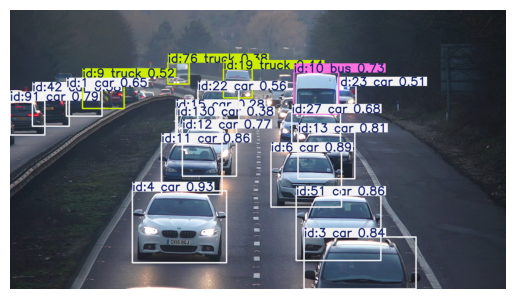

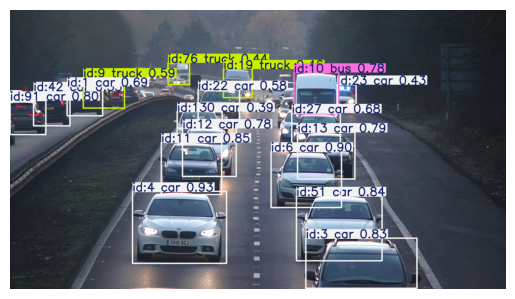

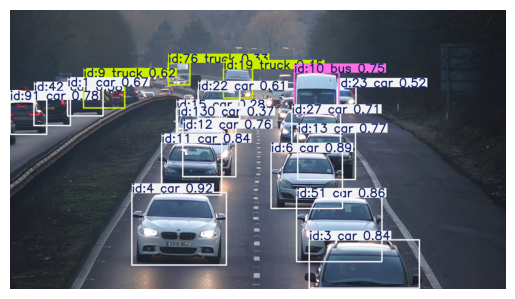

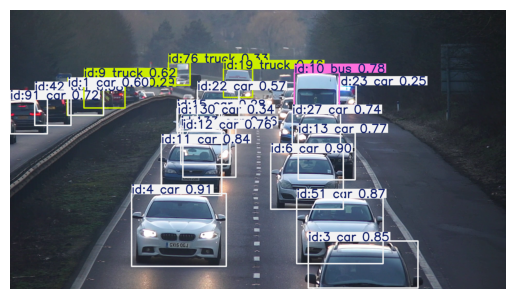

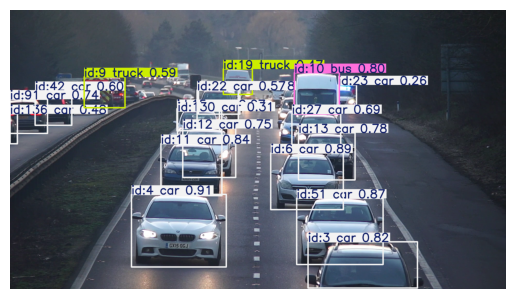

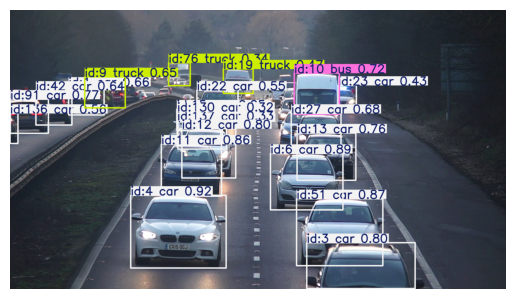

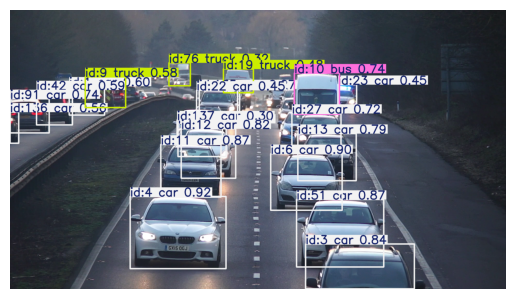

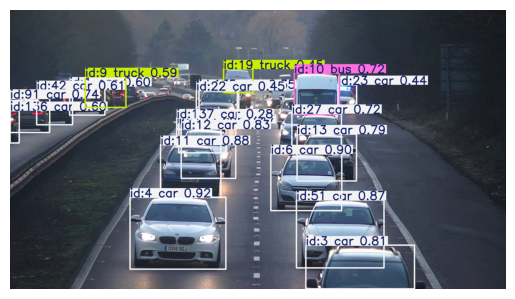

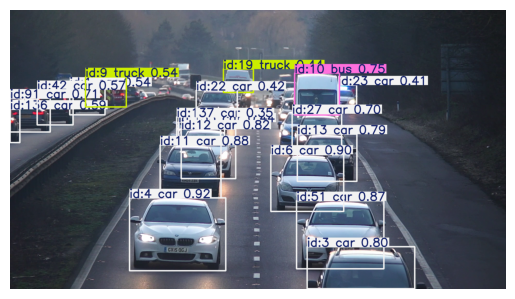

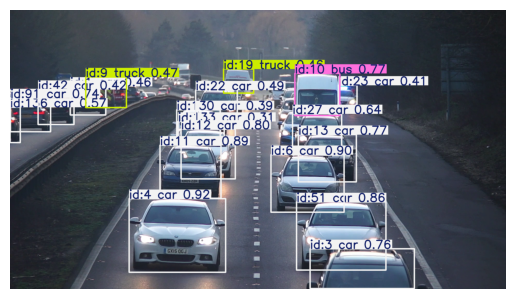

In [47]:
for rst in results:
    vehicle_rgb_img = cv.cvtColor(rst.plot(), cv.COLOR_BGR2RGB)
    plt.imshow(vehicle_rgb_img)
    plt.axis('off')
    plt.show()

In [37]:
aggregated_avg

[{'case': 'local-1-batch', 'average': 1.1233354806900024},
 {'case': 'local-10-batch', 'average': 1.0859703302383423},
 {'case': 'MLIS-1-batch', 'average': 2.794684052467346},
 {'case': 'MLIS-10-batch', 'average': 2.993549942970276},
 {'case': 'MLIS-1-batch-NMS', 'average': 1.3416022539138794}]

In [38]:
pd.DataFrame(aggregated_avg)

case   average
0     local-1-batch  1.123335
1    local-10-batch  1.085970
2      MLIS-1-batch  2.794684
3     MLIS-10-batch  2.993550
4  MLIS-1-batch-NMS  1.341602